# Gina Mazza, Ian Derickson, Adam Viray

In [2]:
from sklearn.datasets import fetch_openml
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
MNIST = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
MNIST

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [2]:
X = MNIST[0]
X -= np.mean(X)
X /= np.std(X)

y = np.array([int(x) for x in MNIST[1]])

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [36]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = (torch.randn(n,p)*1e-3)
        self.W_2 = (torch.randn(p,N)*1e-3/np.sqrt(p))
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = (torch.randn(1,p)*1e-3)
        self.b_2 = (torch.randn(1,N)*1e-3/np.sqrt(p))
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
            
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = (self.X @ self.W_1 + self.b_1)  # First linear 
        self.h = torch.sigmoid(self.z)        # Activation
        self.y = (self.h @ self.W_2 + self.b_2)  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass

In [54]:
def L2_regularization(g1,g2): # likes large gamma
    return g1*torch.mean(torch.square(NN.W_1)) + g2*torch.mean(torch.square(NN.W_2))

def L1_regularization(g1,g2): # likes small gamma
    return g1*torch.mean(torch.abs(NN.W_1)) + g2*torch.mean(torch.abs(NN.W_2))

In [60]:
NN = NeuralNet(784,300,10)
eta = 1            # Set learning rate (empirically derived)
gamma1 = 1e-2
gamma2 = 1e-2
with tqdm(total=1000) as pbar:
    for t in range(1000):   # run for 50000 epochs
        y_pred = NN.forward(X_train[:1000])   # Make a prediction
        loss = torch.nn.CrossEntropyLoss()   # Create loss function
        L = loss(y_pred,y_train[:1000]) + L1_regularization(gamma1, gamma2)   # Compute loss
        NN.zero_grad()           # Clear gradient buffer
        L.backward()              # MAGIC: compute dL/d parameter
        for param in NN.parameters:            # update parameters w/
            param.data -= eta*param.grad.data   # GD
        #eta = 5e-2*(100-t)/100
        if t%100==0:         # Print loss    
            print(t,L.item())
        pbar.update(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

0 2.3025925159454346
100 0.27148112654685974
200 0.0548325851559639
300 0.02450699731707573
400 0.015201730653643608
500 0.011019842699170113
600 0.0087083475664258
700 0.0072634522803127766
800 0.00628376379609108
900 0.005580204539000988


tensor(0)


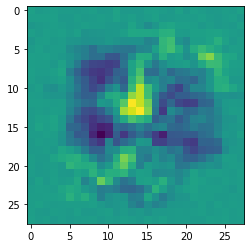

tensor(4)


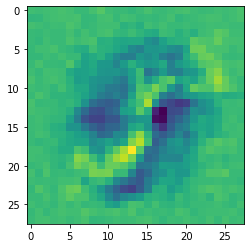

tensor(4)


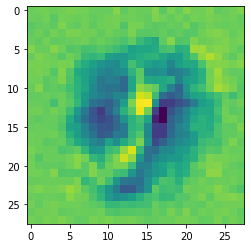

tensor(2)


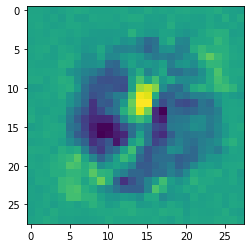

tensor(7)


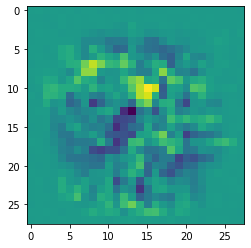

tensor(4)


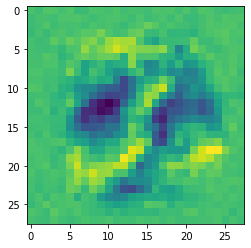

tensor(2)


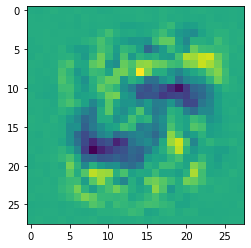

tensor(5)


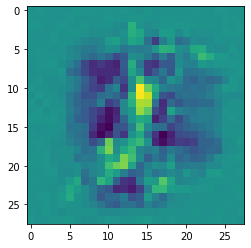

tensor(8)


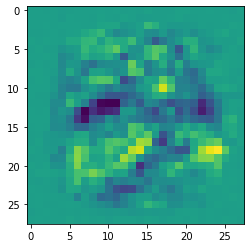

tensor(2)


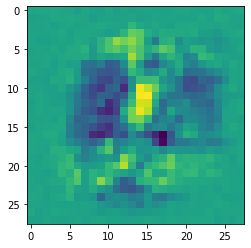

tensor(7)


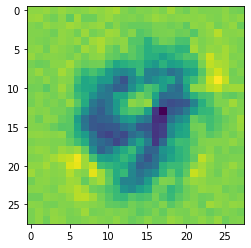

tensor(2)


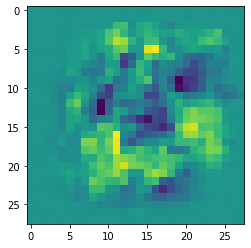

tensor(8)


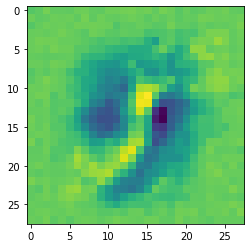

tensor(6)


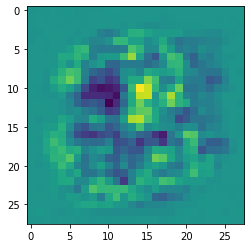

tensor(8)


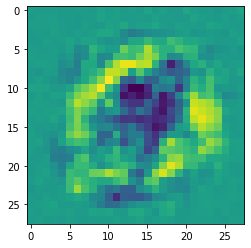

tensor(4)


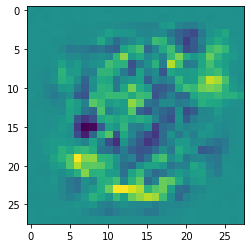

tensor(8)


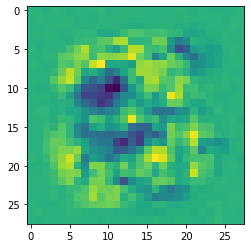

tensor(1)


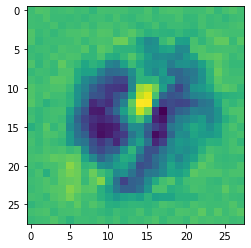

tensor(7)


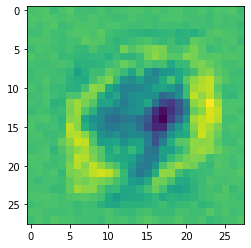

tensor(0)


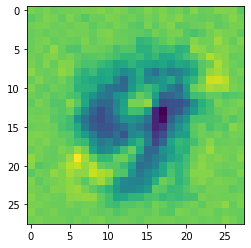

In [61]:
for i in range(20):
    plt.imshow(NN.W_1[:,i].detach().numpy().reshape(28,28))
    print(y_train[i])
    plt.show()